In [2]:
!pip install timm


   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 1.1 MB/s eta 0:00:02
   ------------ --------------------------- 0.8/2.5 MB 1.2 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.5 MB 1.3 MB/s eta 0:00:02
   ------------------------ --------------- 1.6/2.5 MB 1.4 MB/s eta 0:00:01
   ----------------------------- ---------- 1.8/2.5 MB 1.4 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.9 MB 1.9 MB/s eta 0:00:02
   -------------- ------------------------- 1.0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Check if GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
train_dir = r"D:\TEST\train"  
val_dir = r"D:\TEST\val"

# Transforms
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# Datasets
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
val_data = datasets.ImageFolder(val_dir, transform=transform_val)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Class names
classes = train_data.classes
print("Classes:", classes)


Using device: cuda
Classes: ['Aam_ko_Achar', 'Aloo_ko_Achar', 'Alu_Daam', 'Anarsa', 'Bagiya', 'Bhakka', 'Bhutako_Bhat_(fried_rice)', 'Buniya', 'Burger', 'Chatamari', 'Chiya', 'Choila', 'Churpi', 'Dal_Bhat', 'Dal_Pithi', 'Dhikri', 'Dhindo', 'Egg_Curry', 'Gajar_Ko_Halwa', 'Ghongi', 'Gundruk', 'Jeri', 'Kheer', 'Kwati', 'Lalmohon_(Gulab_jamun)', 'Laphing', 'Lassi', 'Lasun_ko_Achar', 'Makkai_ko_Roti', 'Malapua', 'Meat_Curry', 'Momo', 'Mula_ko_Achar', 'Omelette', 'Panipuri', 'Peanut_Chikki', 'Pizza', 'Puri_Sabji', 'Pustakari', 'Rasbari', 'Roti', 'Samosa', 'Sekuwa', 'Selroti', 'Sohan_Papdi', 'Sukuti', 'Thakuwa', 'Thukpa', 'Til_ko_Laddu', 'Yomari']


In [5]:
# -------------------------------------------------------------
# PART 2: Model Initialization and Training Loop
# -------------------------------------------------------------
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(classes))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    train_losses.append(running_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# Save model weights and class info
torch.save({'model_state': model.state_dict(), 'classes': classes}, 'best_food_model.pth')
print("Model saved as best_food_model.pth")


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:120: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Epoch [1/20], Train Loss: 1.2801, Val Loss: 0.5345, Val Acc: 85.88%
Epoch [2/20], Train Loss: 0.3305, Val Loss: 0.3077, Val Acc: 91.27%
Epoch [3/20], Train Loss: 0.1451, Val Loss: 0.2426, Val Acc: 93.60%
Epoch [4/20], Train Loss: 0.0725, Val Loss: 0.2344, Val Acc: 93.60%
Epoch [5/20], Train Loss: 0.0424, Val Loss: 0.2214, Val Acc: 93.79%
Epoch [6/20], Train Loss: 0.0281, Val Loss: 0.2290, Val Acc: 93.49%
Epoch [7/20], Train Loss: 0.0211, Val Loss: 0.2241, Val Acc: 93.96%
Epoch [8/20], Train Loss: 0.0185, Val Loss: 0.2147, Val Acc: 93.90%
Epoch [9/20], Train Loss: 0.0193, Val Loss: 0.2300, Val Acc: 93.85%
Epoch [10/20], Train Loss: 0.0223, Val Loss: 0.2386, Val Acc: 93.63%
Epoch [11/20], Train Loss: 0.0185, Val Loss: 0.2236, Val Acc: 94.28%
Epoch [12/20], Train Loss: 0.0196, Val Loss: 0.2337, Val Acc: 94.28%
Epoch [13/20], Train Loss: 0.0106, Val Loss: 0.2326, Val Acc: 94.23%
Epoch [14/20], Train Loss: 0.0167, Val Loss: 0.2461, Val Acc: 93.74%
Epoch [15/20], Train Loss: 0.0172, Val Loss


Weighted F1-score: 0.9380

Classification Report:
                            precision    recall  f1-score   support

             Aam_ko_Achar       0.76      0.85      0.80        33
            Aloo_ko_Achar       0.92      0.87      0.89        39
                 Alu_Daam       0.90      0.95      0.92        37
                   Anarsa       0.89      0.89      0.89        38
                   Bagiya       0.94      0.86      0.90        37
                   Bhakka       1.00      0.91      0.96        35
Bhutako_Bhat_(fried_rice)       0.94      0.94      0.94       178
                   Buniya       0.91      0.91      0.91        32
                   Burger       1.00      1.00      1.00        31
                Chatamari       0.87      0.79      0.83        43
                    Chiya       0.98      0.99      0.99       251
                   Choila       0.79      0.82      0.80        45
                   Churpi       1.00      0.93      0.97        30
         

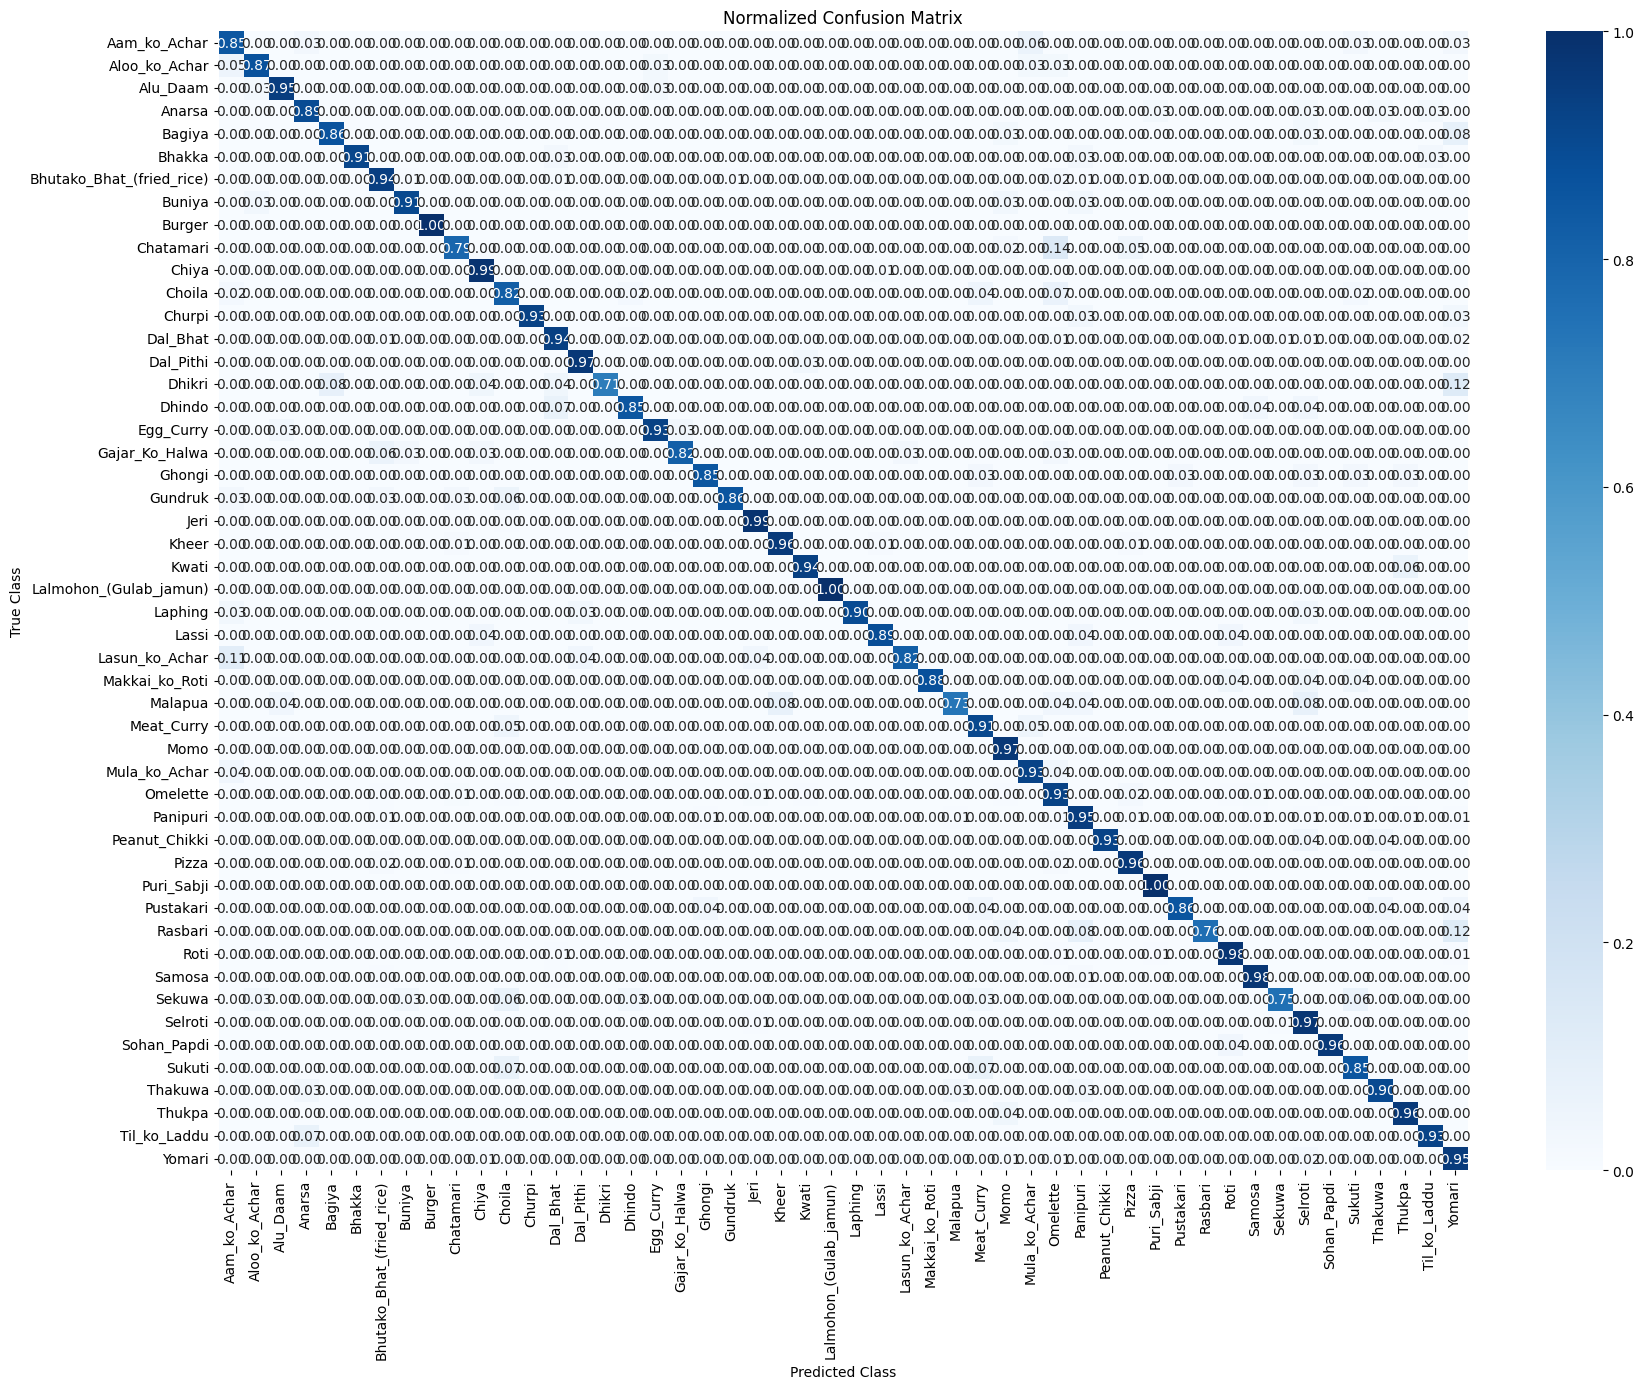

In [7]:
# -------------------------------------------------------------
# PART 3: Evaluate F1-score, Confusion Matrix, Classification Report
# -------------------------------------------------------------
# Assuming 'model', 'val_loader', 'device', 'classes', 'f1_score', 
# 'confusion_matrix', 'classification_report', 'sns', 'plt', and 'np' are available.

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# F1-score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"\nWeighted F1-score: {f1:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=classes))

# --- 📊 Normalized Confusion Matrix Code ---
all_labels = y_true # Renaming for clarity if needed, though y_true is sufficient
all_preds = y_pred

cm = confusion_matrix(all_labels, all_preds)
# Calculate the normalized confusion matrix (rows sum to 1)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(18, 14)) # Large figure size for many classes
sns.heatmap(cm_normalized,
            annot=True,              # Show numeric values
            fmt='.2f',               # Format to 2 decimal places (percentage)
            cmap='Blues',
            xticklabels=classes,     # Use 'classes' (your class names)
            yticklabels=classes)     # Use 'classes' (your class names)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# -------------------------------------------------------------

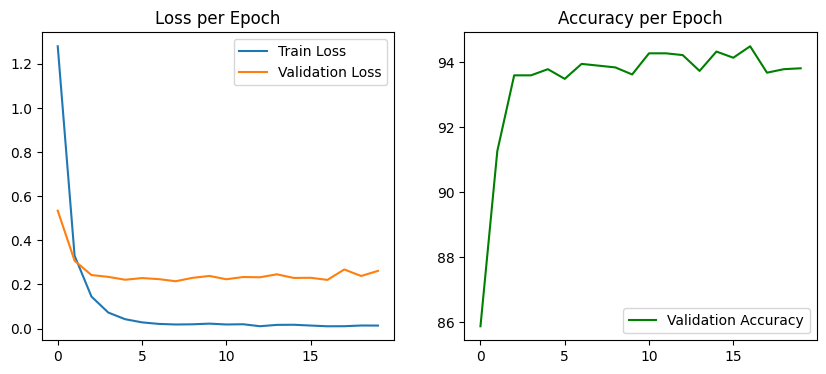

In [8]:
# -------------------------------------------------------------
# PART 4: Accuracy–Loss Graph
# -------------------------------------------------------------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.legend()
plt.title('Accuracy per Epoch')

plt.show()
